### Implementation  of WP 1.4 for the water quality implementation plan:
WP 1.4 (notebook) Methods for analysis of results ‘per waterbody’ / AOI  
- state of the waterbody
- direction of trend in WQ
- change in comparison with a baseline

In [1]:
# ---- dependencies ---
import os
import numpy as np
import xarray as xr
import json
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt


#### Set the time interval and place

In [31]:
# --- global parameters ---
placename = 'SA_smalldam'   #manually setting this for now
placename = 'Lake_Sulunga'   #manually setting this for now
placename = 'Ghana_River'   #manually setting this for now
placename = 'Lake_Tikpan'   #manually setting this for now
placename = 'Lake_vic_turbid'   #manually setting this for now

test    = True
verbose = True
path = '/home/jovyan/dev/deafrica_water_quality/WP1.4/'
wq_dataset_filename        = path+'wp12_ds_'+placename+'.nc'
wq_normalisation_parameters_filename = path+'wq_normalisation_parameters.json'
reference_years = ('2013','2017')
assessment_years = ('2020','2024')
save_figures_as = placename


#### This is a helpful function

In [32]:
from scipy.interpolate import interp1d
def piecewise_linreg(x,y,keepnans=True,test=False):
    #from two series, representing paired  x,y values, this function estimates the value of each y point with a linear regresion of the points either side of it, and itself
    #It alows one to fit a trend line to the series that approximates the data point, rather than going through it, allowing for noise in the data.   
    # the process needs to ignore nans, but the returned sequence must be consistent in x values, so here I remove all nans, do the fits, replace nans
    #this won't work if x is datetime64 because the variables won't stack. 
    
    a      = np.vstack((x,y,y))
    aprime = np.copy(a)
        
    newx = np.argwhere(a.sum(0)>=0)     #no nans in these columns
    xlen = newx.size                
    b    = np.zeros(a.shape[0]*xlen).reshape(a.shape[0],xlen)*np.nan
    for i in np.arange(0,xlen):
        b[:,i] = a[:,newx[i][0]]    
    a = b  

    centre_weighted = True
    for i in range(0,len(a[0])-2) : 
        if centre_weighted:
            y = np.append(a[1][i:i+3],a[1][i+1])
            x = np.append(a[0][i:i+3],a[0][i+1])
            A = np.vstack((np.ones(4)*1.,x))
        else:
            y = a[1][i:i+3]
            x = a[0][i:i+3]
            A = np.vstack((np.ones(3)*1.,x))
                
        (intercept,slope) = sp.linalg.lstsq(A.T,y)[0]
        def f(x) : 
            return (x * slope + intercept).round(3)
        a[2,i+1] = f(a[0][i+1])
        if test : print(f(a[0][i+1]))
        if i == 0  : 
            a[2,i]   = f(a[0][i])
        if i == len(a[0])-3 : 
            if test : print('i = ',i)
            a[2,i+2] = f(a[0][i+2])

    if keepnans:
        #bring back the complete series, with nans:
        for i in range(0,xlen) :
            aprime[:,newx[i][0]] = a[:,i]
        a = aprime
            
    bias,sd = sum(a[2]-a[1]),((a[2]-a[1])**2).sum()**0.5
    if test : print('bias = ',bias.round(3),'sd = ',sd.round(3))
    #return(a[[0,2],:],bias,sd)
    return([a[0,:],a[2,:]],bias,sd)

#### First things first, read in the dataset and normalise the measurements 

In [33]:
def read_dataset_and_parameters(wq_dataset_filename,wq_normalisation_parameters_filename):
    ds   = xr.open_dataset(wq_dataset_filename).load(); ds.close()
    with open(wq_normalisation_parameters_filename) as f:
      np_data_dict = json.load(f)
    return(ds,np_data_dict)


In [34]:
# --- A Function to normalise the WQ measures ---

def normalise_water_quality_measures(ds0,np_data_dict,water_frequency_threshold=0,verbose=True,test=False):
    if test or verbose : print('Applying scale and offset to wq variables..')

    ds = ds0.copy(deep=True)   #without this the ds values do change outside of the function

    #run through all the wq measures; ds should have a dimension called 'tss_measure' and another called 'chla_measure'. 
    for mmt_type in ['tss','chla'] :
        for mmt in list(ds[mmt_type+'_measure']) :
            measurement = str(mmt.values)
            scale  = np_data_dict[measurement]['scale']
            offset = np_data_dict[measurement]['offset']
            ds[mmt_type].loc[:,:,:,measurement] = ds[mmt_type].loc[:,:,:,measurement] * scale + offset
    
    #take the median of the tss and chla measurements from now on:
    water_frequency_threshold=0
    tss_index_list  = ds.tss_measure   # --- which tss measures to include; in practice this include them all  ----
    ds['tss_agm_med' ] = xr.where(ds.wofs_ann_pwater>water_frequency_threshold,
                                  ds.tss.loc[:,:,:,tss_index_list].median(dim=('tss_measure')),np.nan)

    chla_index_list = ds.chla_measure  # --- which chla measures to include; by default, include them all ----
    ds['chla_agm_med'] = xr.where(ds.wofs_ann_pwater>water_frequency_threshold,
                                  ds.chla.loc[:,:,:,chla_index_list].median(dim=('chla_measure')),np.nan)

    #drop excess material
    if not test:
        ds = ds.drop_vars('tss','chla')
    return ds

In [35]:
# --- important to run these together; don't want to run the normalisation process twice on the same data! ---

ds,np_data_dict = read_dataset_and_parameters(wq_dataset_filename,wq_normalisation_parameters_filename)
ds = normalise_water_quality_measures(ds,np_data_dict,water_frequency_threshold = 0.9,verbose=verbose,test=test)


Applying scale and offset to wq variables..


#### State of the waterbody
- SDG methods provide trophic state levels:
  Chla uppler limit, TSI:
  ((0.04,0.12,.34,.94,2.6,6.4,20,56,154,427,1183),
  (0   ,10  ,20  ,30 ,40 ,50,60,70,80 ,90 ,100))
- each pixel can be allocated a trophic state index on this basis
- new variable is added 


In [36]:
def trophic_index_level(ds,chla_variable,verbose=verbose,test=test):
    chla_variable       = 'chla_agm_med'
    
    #put the water quality parameters into an array
    
    a = np.asarray([[0.04,0.12,.34,.94,2.6,6.4,20,56,154,427,1183],
                [0   ,10  ,20  ,30 ,40 ,50,60,70,80 ,90 ,100]], dtype = 'float16')
    
    # calculate the trophic state index for the dataset
    trophic_state_index = 'TSI' # --  almost any name will do
    ds[trophic_state_index] = 0 * ds[chla_variable]
    
    for i in np.arange(0,a[1].size-1):
        ds[trophic_state_index] = xr.where(ds[chla_variable] > a[0][i],
                                           a[1][i+1],
                                           ds[trophic_state_index])
    return(ds[trophic_state_index])


In [37]:
# per-pixel TSI 
ds['TSI']  = trophic_index_level(ds,'chla_agm_med')

#### Changes in comparison to a baseline:
##### The documented SDG methods are applied as closely as possible. A difference is that the DE Africa data used are anuual composites
- LKRV_PWAC lake and river permanent water area change
- LKW_QLTRB  tubidity change
- LKW_QLTRST trophic state change
- 
#### A robust regression is also used to compare the reference period with the assessment period
- the robust regression gives a 'yes' or 'no' about whether the periods are different, based on a 95% confidence level
- also, a  regression line is provided (slope, intercept)
- the robust regression can be used with any parameters (area, tss, chla, TSI)
##### This has the added advantage of picking up IMPROVEMENTS in water quality, unlike the SDG methods

In [38]:
def robust_regression (ds,variable,reference_years,assessment_years,option='median',verbose=verbose,test=test):
    times = np.hstack(
        (
        ds.sel(time=slice(reference_years[0],reference_years[1])).time,
        ds.sel(time=slice(assessment_years[0],assessment_years[1])).time
        )
        )
    if option == 'median':
        series = np.hstack(
        (
        ds[variable].sel(time=slice(reference_years[0],reference_years[1])).median(dim=('x','y')),
        ds[variable].sel(time=slice(assessment_years[0],assessment_years[1])).median(dim=('x','y')))
        )
    if option == 'mean':
        series = np.hstack(
        (
        ds[variable].sel(time=slice(reference_years[0],reference_years[1])).mean(dim=('x','y')),
        ds[variable].sel(time=slice(assessment_years[0],assessment_years[1])).mean(dim=('x','y')))
        )
    if option == 'sum':
        series = np.hstack(
        (
        ds[variable].sel(time=slice(reference_years[0],reference_years[1])).sum(dim=('x','y')),
        ds[variable].sel(time=slice(assessment_years[0],assessment_years[1])).sum(dim=('x','y')))
        )
    if option == 'count':
        series = np.hstack(
        (
        ds[variable].sel(time=slice(reference_years[0],reference_years[1])).count(dim=('x','y')),
        ds[variable].sel(time=slice(assessment_years[0],assessment_years[1])).count(dim=('x','y')))
        )

    # --- replace infinite values with nans and nans with the mean of the series --- 
    if test: print(series)
    series = np.where(np.isinf(series),np.nan,series)
    series = np.where(np.isnan(series),np.nanmean(series),series)
    if test: print(series)
    
    slope,intercept,slope_low,slope_high = sp.stats.theilslopes(series,times,method='separate')
    significant = np.sign(slope_low) == np.sign(slope_high)
    declining   = significant and (slope_high < 0)
    increasing  = significant and (slope_low > 0)

    # --- the slope is the important parameter, but a better estimate of the intercept is useful for graphing purposes ---
    
    if option == 'median' or option == 'mean':
        ymean = np.mean(
        (ds[variable].sel(time=slice(reference_years[0],reference_years[1])).mean(dim=('x','y')).mean().values,
        ds[variable].sel(time=slice(assessment_years[0],assessment_years[1])).mean(dim=('x','y')).mean().values)
        )
    if option == 'count' or option == 'sum':
        ymean = np.mean(
        (ds[variable].sel(time=slice(reference_years[0],reference_years[1])).sum(dim=('x','y')).mean().values,
        ds[variable].sel(time=slice(assessment_years[0],assessment_years[1])).sum(dim=('x','y')).mean().values)
        )
    modelmean = np.mean(
        (ds.time.sel(time=reference_years[0]).astype('float'),
         ds.time.sel(time=assessment_years[1]).astype('float'))
        ) * slope
    
    if not (np.isnan(ymean - modelmean)): intercept = ymean-modelmean  #if the method returns nans then revert ...

    if  False:
        print('\n Affected = ',significant,
              '\n Declining = ',declining)
    parameters = dict(slope = slope,
                      intercept=intercept,
                      slope_low=slope_low,
                      slope_high=slope_high,
                      significant = significant,
                      declining=declining,
                      increasing=increasing)
    if test: 
        print(times.astype('float'))
        print(series)
        print(times.astype('float')*slope + intercept)
        print('')
    return(parameters)

#### Permanent Water Area change

In [39]:
def SDG_LKRV_PWAC(ds,reference_years,assessment_years,water_freq_thresholds=[0,.15,.875],verbose=verbose,test=test):
    # --- calculate the changes in permanent water area using the approach described in the SDG methods
    # --- descide if the area is permanent water in the reference and assessment intervals
    # --- having worked through a range of options, the SDG appraoch seems pretty good. Much of the material in here at this point is not critical; it can be trimmed down
    # --- the results obtained from the SDG method are very similar to taking the median of the annual permanent water area for the reference / assessment periods

    reference  = ds.drop_dims(('time','chla_measure','tss_measure'),errors='ignore')
    assessment = ds.drop_dims(('time','chla_measure','tss_measure'),errors='ignore')
    pwater_threshold = water_freq_thresholds[0]
    water_threshold  = water_freq_thresholds[1]
    ephemeral_water_threshold = water_freq_thresholds[2]

    # --- as a start, run a statistical regression on the median data from the two time periods --- 
    ds['wofs_ann_pwater_nonzero'] = xr.where(np.logical_or(ds['wofs_ann_pwater']==0,np.isnan(ds['wofs_ann_pwater'])),np.nan,ds['wofs_ann_pwater'])
    regression = robust_regression(ds,'wofs_ann_pwater_nonzero',reference_years,assessment_years,'count',
                                   verbose=verbose,test = test)
    cell_area = ((ds.x[1] - ds.x[0]) * (ds.y[1] - ds.y[0])) / 1000000
    reference['wofs_wetcount']     = ds['wofs_ann_wetcount'].sel(time=slice(reference_years[0],reference_years[1])).sum(dim='time')
    reference['wofs_clearcount']   = ds['wofs_ann_clearcount'].sel(time=slice(reference_years[0],reference_years[1])).sum(dim='time')
    reference['wofs_freq_median']  = ds['wofs_ann_freq'].sel(time=slice(reference_years[0],reference_years[1])).median(dim='time')                                         
    reference['wofs_freq']         = reference.wofs_wetcount / reference.wofs_clearcount
    reference['wofs_freq_sdv']     = ((reference.wofs_freq * (1.0 - reference.wofs_freq) )/ (reference.wofs_clearcount - 1)) ** 0.5
    reference['wofs_pwater_threshold']  = (-1 * reference.wofs_freq_sdv * 1.2) + pwater_threshold

    # ---  two ways of calculation of the area of permanent water for the reference period -- 
    reference['pwater_wofs_freq_method'] = xr.where(reference.wofs_freq > reference.wofs_pwater_threshold,1,0)
 
    # --- permanent water is based on whether the water is permanent in more years than not ---
    #     code below compares how many times each pixel is permanent water, rather than other water. 
    #     The dataset pwater variable should:
    #     -be nan for non-water areas, 
    #     -be zero for areas that are not permanent water, and 
    #     -be >0 for permanent water areas.

    # --- count the number of times a pixel has been non-nan, and pwater>0, and compare with the count for when it has had pwater <> 0
    reference['pwater_sdg_method'] =\
        (xr.where(
        xr.where(np.logical_and
          (
           ~np.isnan(ds.wofs_ann_pwater.sel(time=slice(reference_years[0],reference_years[1]))),
                     ds.wofs_ann_pwater.sel(time=slice(reference_years[0],reference_years[1])) >0
          ),1,0).sum(dim='time')
        >
        xr.where(np.logical_and
          (
           ~np.isnan(ds.wofs_ann_pwater.sel(time=slice(reference_years[0],reference_years[1]))),
                   ~(ds.wofs_ann_pwater.sel(time=slice(reference_years[0],reference_years[1])) >0)
          ),1,0).sum(dim='time'),
        1,0))

    # --- encode water as 0,1,2,3 (no water, ephemeral, seasonal, permanent --- 
    reference['water'] = reference.pwater_sdg_method +\
                         xr.where(reference.wofs_freq > water_threshold,1,0) + \
                         xr.where(reference.wofs_freq > ephemeral_water_threshold,1,0)

    # --- repeat the analysis for the assessment years ---
    
    assessment['wofs_wetcount']    = ds['wofs_ann_wetcount'].sel(time=slice(assessment_years[0],assessment_years[1])).sum(dim='time')
    assessment['wofs_clearcount']  = ds['wofs_ann_clearcount'].sel(time=slice(assessment_years[0],assessment_years[1])).sum(dim='time')
    assessment['wofs_freq_median'] = ds['wofs_ann_freq'].sel(time=slice(assessment_years[0],assessment_years[1])).median(dim='time')
    assessment['wofs_freq']        = assessment.wofs_wetcount / assessment.wofs_clearcount
    assessment['wofs_freq_sdv']    = ((assessment.wofs_freq * (1.0 - assessment.wofs_freq) )/ (assessment.wofs_clearcount - 1)) ** 0.5
    assessment['wofs_pwater_threshold']  = (-1 * assessment.wofs_freq_sdv * 1.2) + pwater_threshold
    # ---  two ways of calculation of the area of permanent water for the reference period -- 
    assessment['pwater_wofs_freq_method'] = xr.where(assessment.wofs_freq > assessment.wofs_pwater_threshold,1,0)

    # --- permanent water is based on whether the water is permanent in more years than not ---
    assessment['pwater_sdg_method'] =\
        (xr.where(
        xr.where(np.logical_and
          (
           ~np.isnan(ds.wofs_ann_pwater.sel(time=slice(assessment_years[0],assessment_years[1]))),
                     ds.wofs_ann_pwater.sel(time=slice(assessment_years[0],assessment_years[1])) >0
          ),1,0).sum(dim='time')
        >
        xr.where(np.logical_and
          (
           ~np.isnan(ds.wofs_ann_pwater.sel(time=slice(assessment_years[0],assessment_years[1]))),
                   ~(ds.wofs_ann_pwater.sel(time=slice(assessment_years[0],assessment_years[1])) >0)
          ),1,0).sum(dim='time'),
        1,0))

    assessment['water'] = assessment.pwater_sdg_method  +\
                         xr.where(assessment.wofs_freq > water_threshold,1,0) + \
                         xr.where(assessment.wofs_freq > ephemeral_water_threshold,1,0)

    # --- the sdg method is very long-winded ....
    alpha    = drytopermanent       = ((np.logical_and(reference.water == 0,assessment.water==3)).sum()*cell_area).values
    beta     = permanenttodry       = ((np.logical_and(reference.water == 3,assessment.water==0)).sum()*cell_area).values
    phi      = seasonaltopermanent  = ((np.logical_and(reference.water == 2,assessment.water==3)).sum()*cell_area).item(0)
    sigma    = permanenttoseasonal  = ((np.logical_and(reference.water == 3,assessment.water==2)).sum()*cell_area).item(0)
    epsilon  = permanenttopermanet  = ((np.logical_and(reference.water == 3,assessment.water==3)).sum()*cell_area).item(0)
    delta  = (((alpha - beta) + (phi-sigma))/(epsilon + beta + sigma))*100
    # --- same result more directly :
    pwater_assessment               = ((np.logical_and(True,assessment.water==3)).sum()*cell_area).item(0)
    pwater_reference                = ((np.logical_and(reference.water==3,True)).sum()*cell_area).item(0)
 
    # --- other water can be taken as 'seasonal' for these purposes
    swater_reference                = ((np.logical_and(reference.water  >0,reference.water <3)).sum()*cell_area).item(0)
    swater_assessment               = ((np.logical_and(assessment.water >0,assessment.water<3)).sum()*cell_area).item(0)

    
    lkrv_pwac  = dict(
                      years    = [reference_years,assessment_years],
                      pwater_km2_ref    = pwater_reference,
                      pwater_km2_ass    = pwater_assessment,
                      pwater_km2_change  = pwater_assessment - pwater_reference,
                      pwater_change_pc   = np.round((pwater_assessment/pwater_reference - 1.0)*100,2),
                      swater_km2_ref    = swater_reference,
                      swater_km2_ass    = swater_assessment,
                      reg_significant_pwa  = regression['significant'],
                      pwater_increasing =   (regression['significant'] and regression['slope'] > 0),
                      pwater_decreasing =   (regression['significant'] and regression['slope'] < 0),
                      reg_slope_pwa              =  regression['slope'],
                      reg_intercept_pwa          =  regression['intercept'],
                      reg_slope_low_pwa          =  regression['slope_low'],
                      reg_slope_high_pwa          =  regression['slope_high'],
                     )

    
    if verbose: 
        print(
           '\n Reference years: ',reference_years,
          '\n Assessment years: ',assessment_years,
          '\n Area (km2) of water during reference  years = ',np.round(pwater_reference,3),
          '\n Area (km2) of water during assessment years = ', np.round(pwater_assessment,3),
          '\n lkrv_pwac (%) = ',np.round(lkrv_pwac['pwater_change_pc'],3),
          '\n lkrv_pwac (km2) = ',np.round(lkrv_pwac['pwater_km2_change'],3),
          '\n Significant change = ',lkrv_pwac['pwater_significant'],
          '\n Increase in permanent water = ', lkrv_pwac['pwater_increasing'],
          '\n Deacrease in permanent water = ', lkrv_pwac['pwater_decreasing'],
            )
        
    return (reference,assessment,lkrv_pwac)
    

In [40]:
# Permanent Water Area Changes:
lkrv_pwac = SDG_LKRV_PWAC(ds,reference_years,assessment_years,water_freq_thresholds=[0,.15,.875],verbose=False,test=False)[2]

#### Water Quality Changes - Trophic State Index, ChlA and Turbidity

In [41]:
def SDG_LKW_QL(ds,reference_years,assessment_years,verbose=False,test=False):
    # --- we don't have months, so for this analysis we are only  using annual data, although we have many more pixels.. ---
    # --- compare the mean and median values for each pixel, for the reference and assessment period
    cell_area   = (((ds.x[1]-ds.x[0]) * (ds.y[1]-ds.y[0])) / 1000000).item()
    reference   = ds.drop_dims(('time','chla_measure','tss_measure'),errors='ignore')
    assessment  = ds.drop_dims(('time','chla_measure','tss_measure'),errors='ignore')

    # --- as a start, run a  robust regression on the median data from the two time periods --- 
    TSI_regression  = robust_regression(ds,'TSI',reference_years,assessment_years,'mean',verbose,test)
    tss_regression  = robust_regression(ds,'tss_agm_med',reference_years,assessment_years,'median',verbose,test)
    chla_regression = robust_regression(ds,'chla_agm_med',reference_years,assessment_years,'median',verbose,test)
    

    
    reference ['tss_median']   = ds.tss_agm_med.sel(time=slice(reference_years[0],reference_years[1])).median(dim='time')       
    reference ['chla_median']  = ds.chla_agm_med.sel(time=slice(reference_years[0],reference_years[1])).median(dim='time')       
    reference ['TSI_median']   = ds.TSI.sel(time=slice(reference_years[0],reference_years[1])).median(dim='time')       
    assessment['tss_median']   = ds.tss_agm_med.sel(time=slice(assessment_years[0],assessment_years[1])).median(dim='time')
    assessment['chla_median']  = ds.chla_agm_med.sel(time=slice(assessment_years[0],assessment_years[1])).median(dim='time')
    assessment['TSI_median']   = ds.TSI.sel(time=slice(assessment_years[0],assessment_years[1])).median(dim='time')

    # --- calculate percentage change and trim to 0-100 ---
    pc    = ((assessment.tss_median - reference.tss_median) / reference.tss_median) * 100
    pc    = pc.where(pc<100,100).where(pc>0,0).where(~np.isnan(pc),np.nan)
    # --- calculate the 'affected' classes 1-4
    tss_pc = pc
    tss_affected = pc.where(False,1).where(pc<25,2).where(pc<50,3).where(pc<75,4).where(~np.isnan(pc),np.nan)    
    HE = xr.where(tss_affected > 2,1,0).sum().item()*cell_area
    LM = xr.where(tss_affected < 3,1,0).sum().item()*cell_area
    affected_result = (HE > LM)

    lkw_qltrb  = dict(
                      years              = [reference_years,assessment_years],
                      HE_km2             = HE,
                      LM_km2             = LM,
                      affected           = affected_result,
                      significant        =  tss_regression['significant'],
                      tss_declining      =  tss_regression['declining'],
                      reg_slope_tss      =  tss_regression['slope'],
                      reg_intercept_tss  =  tss_regression['intercept'],
                      reg_slope_low_tss  =  tss_regression['slope_low'],
                      reg_slope_high_tss =  tss_regression['slope_high'],
                      reg_significant_tss =  np.sign(tss_regression['slope_high']) == \
                                             np.sign(tss_regression['slope_low'])

                     )
    
    
    if verbose: print('\n Lake Water Quality Turbidity (tss):',        
        '\n High to Extreme  (km2) = ',lkw_qltrb['HE_km2'],
        '\n Low  to Moderate (km2) = ',lkw_qltrb['LM_km2'],
        '\n Waterbody Affected     = ',lkw_qltrb['affected']==1,
        '\n Significant  Trend     = ',lkw_qltrb['significant'],
        '\n Turbidity declining (improving) = ',lkw_qltrb['tss_declining'],
        )    

    # repeat for TSI and Chl-A
    pc    = ((assessment.TSI_median - reference.TSI_median) / reference.TSI_median) * 100
    pc    = pc.where(pc<100,100).where(pc>0,0).where(~np.isnan(pc),np.nan)
    TSI_pc = pc
    TSI_affected = pc.where(False,1).where(pc<25,2).where(pc<50,3).where(pc<75,4).where(~np.isnan(pc),np.nan)
    HE = xr.where(TSI_affected > 2,1,0).sum().item()*cell_area
    LM = xr.where(TSI_affected < 3,1,0).sum().item()*cell_area
    affected_result = (HE > LM)


    lkw_qltrst  = dict(
                       years     = [reference_years,assessment_years],
                       HE_km2    = HE,
                       LM_km2    = LM,
                       affected       = affected_result,
                       TSI_declining      =  TSI_regression['declining'],
                       reg_slope_TSI      =  TSI_regression['slope'],
                       reg_intercept_TSI  =  TSI_regression['intercept'],
                       reg_slope_low_TSI  =  TSI_regression['slope_low'],
                       reg_slope_high_TSI =  TSI_regression['slope_high'],
                       reg_significant_TSI =  np.sign(TSI_regression['slope_high']) == \
                                              np.sign(TSI_regression['slope_low']),
                       chla_declining      =  chla_regression['declining'],
                       reg_slope_chla      =  chla_regression['slope'],
                       reg_intercept_chla  =  chla_regression['intercept'],
                       reg_slope_low_chla  =  chla_regression['slope_low'],
                       reg_slope_high_chla =  chla_regression['slope_high'],
                       reg_significant_chla = np.sign(chla_regression['slope_high']) == \
                                              np.sign(chla_regression['slope_low'])
                        )
    
    if verbose: print('\n Lake Water Quality Trophic State :',        
        '\n High to Extreme  (km2) = ',lkw_qltrst['HE_km2'],
        '\n Low  to Moderate (km2) = ',lkw_qltrst['LM_km2'],
        '\n Waterbody Affected     = ',lkw_qltrst['affected']==1,
        '\n Significant Trend      = ',lkw_qltrst['reg_significant_TSI'],
        '\n Trophic state declining (improving)  = ',lkw_qltrst['TSI_declining'],
        '\n Chla Significant Trend               = ',lkw_qltrst['reg_significant_chla'],
        '\n Chla declining (improving)           = ',lkw_qltrst['chla_declining'],
        )    
    return(lkw_qltrb,lkw_qltrst)
    

In [42]:
# Water Quality Changes                    
lkw_qltrb,lkw_qltrst = SDG_LKW_QL(ds,reference_years,assessment_years,verbose=False,test=False)


In [43]:
#print overall results:
if test or verbose:
    print('\nTIME PERIODS:')
    print (' Reference Years  : ', reference_years, '\n Assessment Years : ',assessment_years)

    print('\nPERMANENT WATER AREA RESULTS :',lkrv_pwac['years'])
    print('  Area of permanent water (km2) - Reference  : ',lkrv_pwac['pwater_km2_ref'])
    print('  Area of permanent water (lm2) - Assessment : ',lkrv_pwac['pwater_km2_ass'])
    print('  PW area Change                             : ',lkrv_pwac['pwater_km2_change'])
    print('  Significant change in Permanent Water Area : ',lkrv_pwac['reg_significant_pwa'])
    print('  Increase in PWA                            : ',lkrv_pwac['pwater_increasing'])
    print('  Decrease in PWA                            : ',lkrv_pwac['pwater_decreasing'])
    
    print('\nTURBIDITY RESULTS : ',lkw_qltrb['years'])
    print('  Area of High to Extreme  change (km2) : ',lkw_qltrb['HE_km2'])
    print('  Area of Low  to Moderate change (km2) : ',lkw_qltrb['LM_km2'])
    print('  Turbidity Affected                    : ',lkw_qltrb['affected'])
    print('  Significant change in TSS             : ',lkw_qltrb['significant'])
    print('  Decline in TSS (i.e., improvement)    : ',lkw_qltrb['tss_declining'])
    print('\nTROPHIC STATE RESULTS : ',lkw_qltrst['years'])
    print('  Area of High to Extreme  change (km2) : ',lkw_qltrst['HE_km2'])
    print('  Area of Low  to Moderate change (km2) : ',lkw_qltrst['LM_km2'])
    print('  Trophic State Affected                : ',lkw_qltrst['affected'])
    print('  Significant change in TSI             : ',lkw_qltrst['reg_significant_TSI'])
    print('  Decline in TSI  (i.e., improvement)   : ',lkw_qltrst['TSI_declining'])
    print('  Significant change in Chla            : ',lkw_qltrst['reg_significant_chla'])
    print('  Decline in Chla (i.e., improvement)   : ',lkw_qltrst['chla_declining'])


TIME PERIODS:
 Reference Years  :  ('2013', '2017') 
 Assessment Years :  ('2020', '2024')

PERMANENT WATER AREA RESULTS : [('2013', '2017'), ('2020', '2024')]
  Area of permanent water (km2) - Reference  :  61.824000000000005
  Area of permanent water (lm2) - Assessment :  61.824000000000005
  PW area Change                             :  0.0
  Significant change in Permanent Water Area :  True
  Increase in PWA                            :  False
  Decrease in PWA                            :  False

TURBIDITY RESULTS :  [('2013', '2017'), ('2020', '2024')]
  Area of High to Extreme  change (km2) :  0.0
  Area of Low  to Moderate change (km2) :  61.824000000000005
  Turbidity Affected                    :  False
  Significant change in TSS             :  False
  Decline in TSS (i.e., improvement)    :  False

TROPHIC STATE RESULTS :  [('2013', '2017'), ('2020', '2024')]
  Area of High to Extreme  change (km2) :  0.0
  Area of Low  to Moderate change (km2) :  61.824000000000005
  Tro

#### Visualisation of Changes in Permanent Water Area, Turbidity, and Trophic State
- Data points
- Smooth curve through the datapoints
- Values for Reference and Assessment intervals
- Regression lines indicating the overall trend and uncertainty of the slope
- Dealing with extreme cases .... such as lake sulunga which was dry in the reference period of 2006-2010!

In [44]:
#calculations / visualisation / graphs
if True: #calculate statistics :
        summary            = ds.drop_dims(['x','y'])          #create an annual summary by dropping the spatial dimensions
        reference_times    = summary.time.sel(time=slice(reference_years[0],reference_years[1]))
        assessment_times   = summary.time.sel(time=slice(assessment_years[0],assessment_years[1]))
        regression_span    = summary.time.sel(time=slice(reference_years[0],assessment_years[1]))  #note this assumes that the reference years and assessment years are not switched
        cell_area = ((ds.x[1]-ds.x[0]) * (ds.y[1]-ds.y[0])) / 1000000     # --- units are km2
        
        # --- summarise the permanent water area:
        summary['pwater']  = xr.where(np.logical_and(~np.isnan(ds.wofs_ann_pwater),ds.wofs_ann_pwater>0),1,0).sum(dim=('x','y'))*cell_area
        summary['water']   = xr.where(np.logical_and(~np.isnan(ds.wofs_ann_water) ,ds.wofs_ann_water >0),1,0).sum(dim=('x','y'))*cell_area
        summary['tss']     = ds.tss_agm_med.mean(dim=('x','y'))
        summary['tss_q3']  = ds.tss_agm_med.quantile(.75,dim=('x','y'))
        summary['tss_q1']  = ds.tss_agm_med.quantile(.25,dim=('x','y'))
        summary['chla']    = ds.chla_agm_med.mean(dim=('x','y'))
        summary['chla_q3']    = ds.chla_agm_med.quantile(0.75,dim=('x','y'))
        summary['chla_q1']    = ds.chla_agm_med.quantile(0.25,dim=('x','y'))
        summary['TSI']        = ds.TSI.mean(dim=('x','y'))

        # --- replace infinite values, if they occur, with nans --- 
        for varname in list(summary.data_vars):
            summary[varname] = ('time'), np.where(np.isinf(summary[varname]),np.nan,summary[varname])
    
        minmax_water = [summary.water.min().item(),summary.water.max().item()]
        minmax_pw    = [summary.pwater.min().item(),summary.pwater.max().item()]
        minmax_tss   = [summary.tss.min().item()  ,summary.tss.max().item()]
        minmax_chla   = [summary.chla.min().item(),summary.chla.max().item()]
        minmax_TSI   = [summary.TSI.min().item(),summary.TSI.max().item()]
     
        # --- summarise the water area and quality for refence and assessment intervals ---
        pw_area_reference    =  np.round(summary['pwater'].sel(time=slice(reference_years[0],reference_years[1])).median().item(0),3)
        pw_area_sdg_reference=  lkrv_pwac['pwater_km2_ref']
    
        pw_area_assessment   =  np.round(summary['pwater'].sel(time=slice(assessment_years[0],assessment_years[1])).median().item(0),3)
        pw_area_sdg_assessment =  lkrv_pwac['pwater_km2_ass']
    
        pw_change            =  ((pw_area_sdg_assessment - pw_area_sdg_reference))
        pw_change_percent    =  np.round((pw_change/pw_area_sdg_reference) * 100,2)
    
        TSI_mean_reference   =  np.round(summary['TSI'].sel(time=slice(reference_years[0],reference_years[1])).mean().item(0),2)
        TSI_mean_assessment  =  np.round(summary['TSI'].sel(time=slice(assessment_years[0],assessment_years[1])).mean().item(0),2)
        TSI_change_percent   =  np.round((TSI_mean_assessment/TSI_mean_reference - 1.0) * 100,2)
    
        tss_mean_reference   =  np.round(summary['tss'].sel(time=slice(reference_years[0],reference_years[1])).mean().item(0),1)
        tss_q1_reference     =  np.round(summary['tss'].sel(time=slice(reference_years[0],reference_years[1])).quantile(.25,()).item(0),1)
        tss_q3_reference     =  np.round(summary['tss'].sel(time=slice(reference_years[0],reference_years[1])).quantile(.75,()).item(0),1)
        tss_mean_assessment  =  np.round(summary['tss'].sel(time=slice(assessment_years[0],assessment_years[1])).mean().item(0),1)
        tss_change_percent   =  np.round(((tss_mean_assessment/tss_mean_reference - 1.0) * 100),2)
        
    
        chla_mean_reference  =  np.round(summary['chla'].sel(time=slice(reference_years[0],reference_years[1])).mean().item(0),1)
        chla_q1_reference    =  np.round(summary['chla'].sel(time=slice(reference_years[0],reference_years[1])).quantile(.25,()).item(0),1)
        chla_q3_reference    =  np.round(summary['chla'].sel(time=slice(reference_years[0],reference_years[1])).quantile(.75,()).item(0),1)
        chla_mean_assessment =  np.round(summary['chla'].sel(time=slice(assessment_years[0],assessment_years[1])).mean().item(0),1)
        chla_change_percent   =  np.round((chla_mean_assessment/chla_mean_reference - 1.0) * 100,2)
    

In [45]:
tss_interp(summary.time)

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

pwater


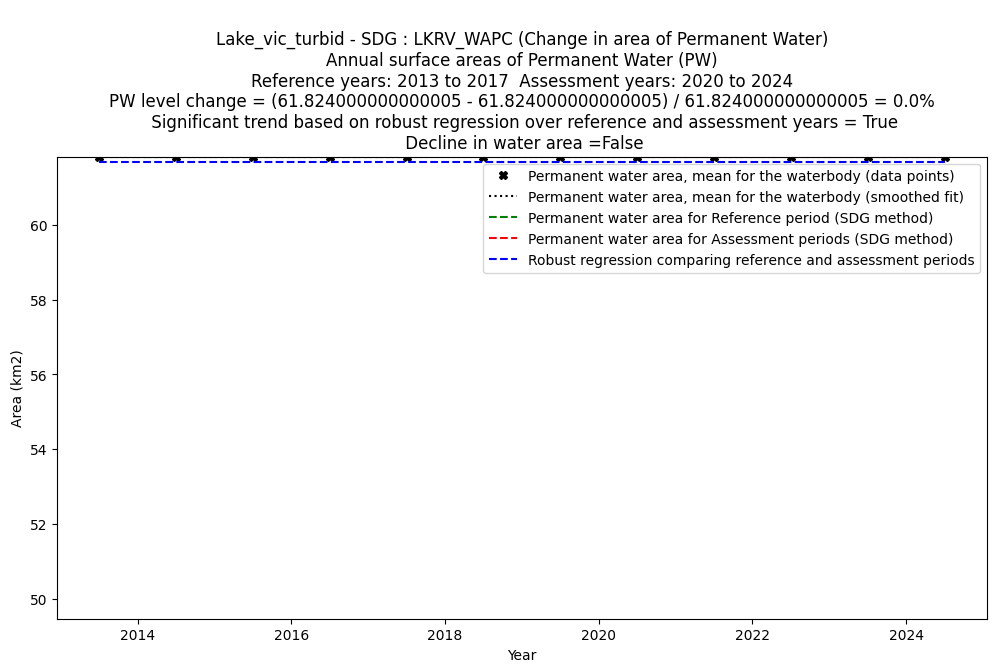

tss


<Figure size 640x480 with 0 Axes>

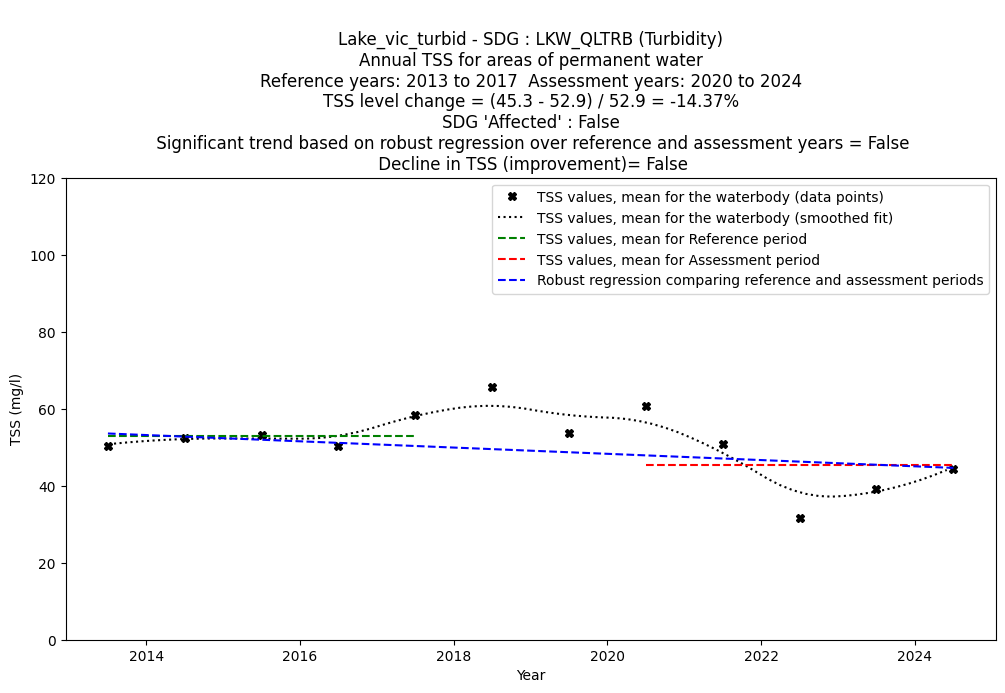

chla


<Figure size 640x480 with 0 Axes>

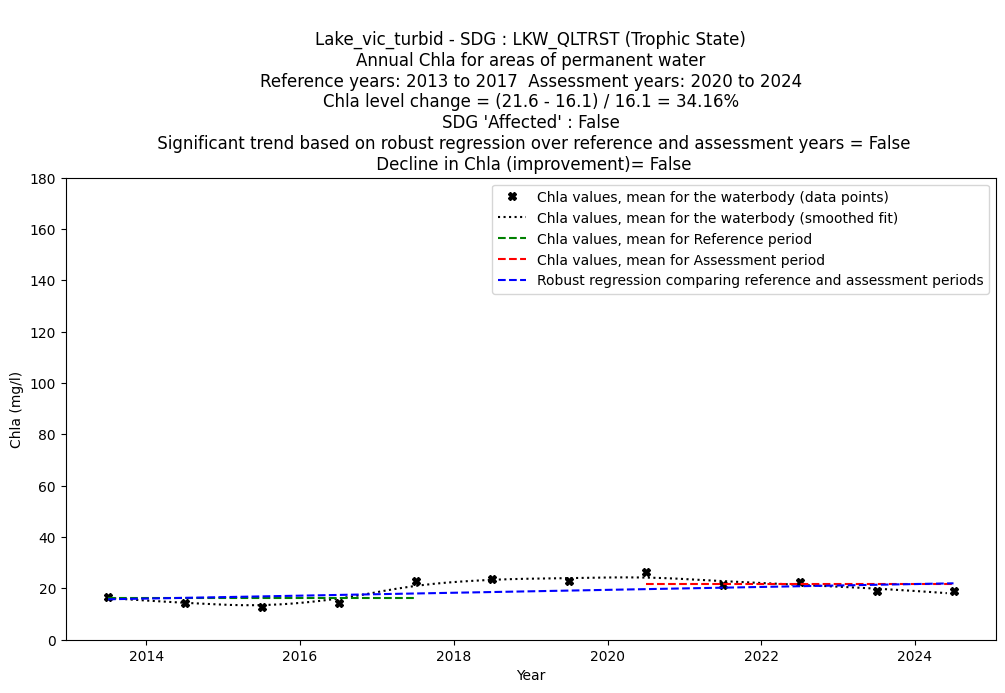

TSI


<Figure size 640x480 with 0 Axes>

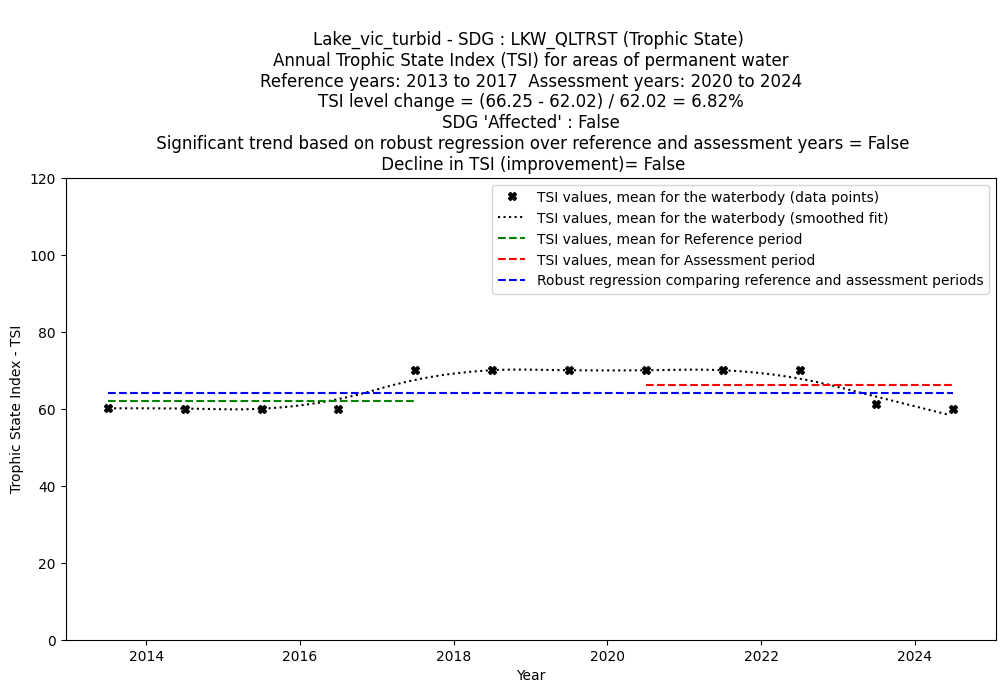

<Figure size 640x480 with 0 Axes>

In [46]:
if verbose: #plot water variations over time:
        # --- fit some trend curves to the data for visualisation using two-step process - a piecewise linear regression followed by a quadratic interpolator --- 
        
        t_new        = pd.date_range(summary.time.min().values, summary.time.max().values, freq='2M')  
        W_interp     = sp.interpolate.interp1d(summary.time,(piecewise_linreg(np.arange(0,summary.time.size),summary.water)[0][1]),kind='quadratic',fill_value='extrapolate')
        PW_interp    = sp.interpolate.interp1d(summary.time,(piecewise_linreg(np.arange(0,summary.time.size),summary.pwater)[0][1]),kind='quadratic',fill_value='extrapolate')
        TSI_interp   = sp.interpolate.interp1d(summary.time,(piecewise_linreg(np.arange(0,summary.time.size),summary.TSI)[0][1]),kind='quadratic',fill_value='extrapolate')
        tss_interp   = sp.interpolate.interp1d(summary.time,(piecewise_linreg(np.arange(0,summary.time.size),summary.tss)[0][1]),kind='quadratic',fill_value='extrapolate')
        chla_interp   = sp.interpolate.interp1d(summary.time,(piecewise_linreg(np.arange(0,summary.time.size),summary.chla)[0][1]),kind='quadratic',fill_value='extrapolate')

        #water quality  parameters and change:

        pwater_text = dict(
                        t2= "\nReference years: " +
                                str(reference_years[0])+' to ' +
                                str(reference_years[1]) +
                                "  Assessment years: " +
                                str(assessment_years[0])+' to ' +
                                str(assessment_years[1]),
                        t1 = '\n'+placename+' - SDG : LKRV_WAPC (Change in area of Permanent Water)\nAnnual surface areas of Permanent Water (PW)',
                        t3 = "\nPW level change = ",
                        t4 = "("+str(pw_area_sdg_assessment)+" - "+str(pw_area_sdg_reference)+") / "+str(pw_area_sdg_reference)+" = "+str(pw_change_percent)+"%",
                        t6 = "\n Decline in water area ="+str(lkrv_pwac['pwater_decreasing']),
                        t7 = "",
                        t5 = "\n Significant trend based on robust regression over reference and assessment years = "+str(lkrv_pwac['reg_significant_pwa']),
                        l2 = 'Permanent water area, mean for the waterbody (smoothed fit)',
                        l1 = 'Permanent water area, mean for the waterbody (data points)',
                        l3 = 'Permanent water area for Reference period (SDG method)',
                        l4 = 'Permanent water area for Assessment periods (SDG method)',
                        l5 = 'Robust regression comparing reference and assessment periods',
                        labely = "Area (km2)",
                        labelx = "Year",
                        filename = save_figures_as+'_lkrv_pwac',
                        )
        pwater_data  = dict(varname = 'pw',
                        ref_mean = pw_area_sdg_reference,
                        ass_mean = pw_area_sdg_assessment,
                        minmax   = minmax_pw,
                        interp   = PW_interp,
                        regression_span      = regression_span,
                        regression_slope     = lkrv_pwac['reg_slope_pwa'],
                        regression_intercept = lkrv_pwac['reg_intercept_pwa'],
                        regression_scale     = cell_area,
                        )
        tss_text = dict(
                        t2= pwater_text['t2'],
                        t1 = '\n'+placename+' - SDG : LKW_QLTRB (Turbidity)\nAnnual TSS for areas of permanent water',
                        t3 = "\nTSS level change = ",
                        t4 = "("+str(tss_mean_assessment)+" - "+str(tss_mean_reference)+") / "+str(tss_mean_reference)+" = "+str(tss_change_percent)+"%",
                        t5 = "\nSDG 'Affected' : "+str(lkw_qltrb['affected']),
                        t6 = "\n Significant trend based on robust regression over reference and assessment years = "+str(lkw_qltrb['reg_significant_tss']),
                        t7 = '\n Decline in TSS (improvement)= '+str(lkw_qltrb['tss_declining']),
                        l2 = 'TSS values, mean for the waterbody (smoothed fit)',
                        l1 = 'TSS values, mean for the waterbody (data points)',
                        l3 = 'TSS values, mean for Reference period',
                        l4 = 'TSS values, mean for Assessment period',
                        l5 = 'Robust regression comparing reference and assessment periods',
                        labely = "TSS (mg/l)",
                        labelx = "Year",
                        filename = save_figures_as+'_lkw_qltrb',
                       )
        tss_data  = dict(varname = 'tss',
                        ref_mean = tss_mean_reference,
                        ass_mean = tss_mean_assessment,
                        #minmax   = minmax_tss,
                        minmax   = [0,np.max((100,tss_mean_reference,tss_mean_assessment))],
                        interp   = tss_interp,
                        regression_span      = regression_span,
                        regression_slope     = lkw_qltrb['reg_slope_tss'],
                        regression_intercept = lkw_qltrb['reg_intercept_tss'],
                        regression_scale     = 1,
                        )
        
                         
        chla_text = dict(
                        t2= pwater_text['t2'],
                        t1 = '\n'+placename+' - SDG : LKW_QLTRST (Trophic State)\nAnnual Chla for areas of permanent water',
                        t3 = "\nChla level change = ",
                        t4 = "("+str(chla_mean_assessment)+" - "+str(chla_mean_reference)+") / "+str(chla_mean_reference)+" = "+str(chla_change_percent)+"%",
                        t5 = "\nSDG 'Affected' : "+str(lkw_qltrst['affected']),
                        t6 = "\n Significant trend based on robust regression over reference and assessment years = "+str(lkw_qltrst['reg_significant_chla']),
                        t7 = '\n Decline in Chla (improvement)= '+str(lkw_qltrst['chla_declining']),
                        l2 = 'Chla values, mean for the waterbody (smoothed fit)',
                        l1 = 'Chla values, mean for the waterbody (data points)',
                        l3 = 'Chla values, mean for Reference period',
                        l4 = 'Chla values, mean for Assessment period',
                        l5 = 'Robust regression comparing reference and assessment periods',
                        labely = "Chla (mg/l)",
                        labelx = "Year",
                        filename = save_figures_as+'_lkw_qltrst_chla',
                       )
        chla_data  = dict(varname = 'chla',
                        ref_mean = chla_mean_reference,
                        ass_mean = chla_mean_assessment,
                        minmax   = [0,150],
                        #minmax   = minmax_chla,
                        interp   = chla_interp,
                        regression_span      = regression_span,
                        regression_slope     = lkw_qltrst['reg_slope_chla'],
                        regression_intercept = lkw_qltrst['reg_intercept_chla'],
                        regression_scale     = 1,                          
                         )
                          
        TSI_text = dict(
                        t2= pwater_text['t2'],
                        t1 = '\n'+placename+' - SDG : LKW_QLTRST (Trophic State) \nAnnual Trophic State Index (TSI) for areas of permanent water',
                        t3 = "\nTSI level change = ",
                        t4 = "("+str(TSI_mean_assessment)+" - "+str(TSI_mean_reference)+") / "+str(TSI_mean_reference)+" = "+str(TSI_change_percent)+"%",
                        t5 = "\nSDG 'Affected' : "+str(lkw_qltrst['affected']),
                        t6 = "\n Significant trend based on robust regression over reference and assessment years = "+str(lkw_qltrst['reg_significant_TSI']),
                        t7 = '\n Decline in TSI (improvement)= '+str(lkw_qltrst['TSI_declining']),
                        l2 = 'TSI values, mean for the waterbody (smoothed fit)',
                        l1 = 'TSI values, mean for the waterbody (data points)',
                        l3 = 'TSI values, mean for Reference period',
                        l4 = 'TSI values, mean for Assessment period',
                        l5 = 'Robust regression comparing reference and assessment periods',
                        labely = "Trophic State Index - TSI",
                        labelx = "Year",
                        filename = save_figures_as+'_lkw_qltrst_TSI',
                       )
        TSI_data  = dict(varname = 'TSI',
                        ref_mean = TSI_mean_reference,
                        ass_mean = TSI_mean_assessment,
                        #minmax   = minmax_TSI,
                        minmax   = [0,100],
                        interp   = TSI_interp,
                        regression_span      = regression_span,
                        regression_slope     = lkw_qltrst['reg_slope_TSI'],
                        regression_intercept = lkw_qltrst['reg_intercept_TSI'],
                        regression_scale     = 1,                          
                         )
                          
        alltext = dict(pwater=pwater_text, tss=tss_text, chla=chla_text, TSI=TSI_text)
        alldata = dict(pwater=pwater_data, tss=tss_data, chla=chla_data, TSI=TSI_data)

        varname = ''
        ref_mean = ''
        ass_mean = ''
        minmax   = ''
        interp   = ''

        text = ''
        for varname in list(('pwater','tss','chla','TSI')):
            print(varname)
            text = alltext[varname]
            data = alldata[varname]
            filename = text['filename']
            ref_mean = data['ref_mean']
            ass_mean = data['ass_mean']
            minmax   = data['minmax']
            interp   = data['interp']
            regression_span = data['regression_span']
            regression_slope = data['regression_slope']
            regression_intercept = data['regression_intercept']
            regression_scale     = data['regression_scale']
            
            plt.figure(figsize=[12, 6])
        
            # --- actual plots, organised to suit legend  ---
            plt.plot(summary.time,summary[varname],'k',linestyle="", marker="X")  #acutal data points
            plt.plot(t_new,np.clip(interp(t_new),0,minmax[1]),'k',linestyle="dotted")
            plt.plot(reference_times,np.ones(reference_times.size)*ref_mean,'g',linestyle="dashed", marker="none")  #acutal data points
            plt.plot(assessment_times,np.ones(assessment_times.size)*ass_mean,'r',linestyle="dashed", marker="none")  #acutal data points

            plt.plot(regression_span,(((regression_span.astype('float')*regression_slope) + regression_intercept)*regression_scale),'b',linestyle="--", marker="none")  # robust regression line


            plt.title(
                text['t1']+text['t2']+text['t3']+text['t4']+text['t5']+text['t6']+text['t7']
                 )
            plt.ylabel(text['labely'])
            plt.xlabel(text['labelx'])
            plt.legend(
                [text['l1'],text['l2'],text['l3'],text['l4'],text['l5']
                ])

            # --- parameters for the range of the plot --- 
            yrange = minmax[1]-minmax[0]
            ymin   = minmax[0] * 0.8 
            ymax   = minmax[1] + 0.2 * yrange
            plt.ylim(ymin,ymax)
            plt.show()    
            plt.savefig(filename+'.png',dpi=150)


    #return(summary,ds)

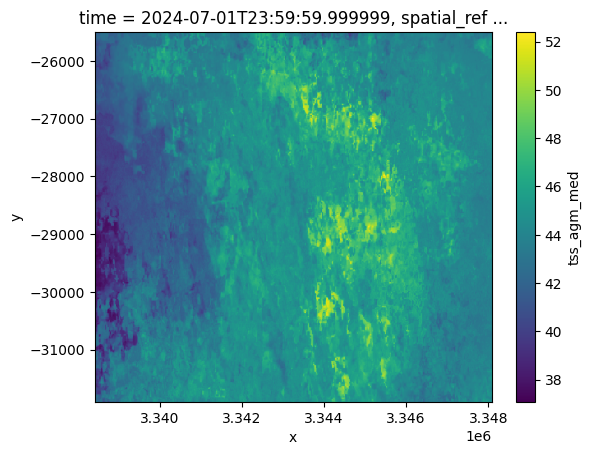

In [47]:
ds.tss_agm_med.sel(time='2024').plot()